# Supervised Learning Use Case: Predicting Presence of Cancer

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn 
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import linear_model
from sklearn import preprocessing
np.set_printoptions(suppress=True)
from IPython.display import display
pd.options.display.float_format = '{:.3f}'.format

/Users/fnkyazn/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### References:
1. Feature selection for regularization algorithms(?): https://stats.stackexchange.com/questions/149446/do-we-still-need-to-do-feature-selection-while-using-regularization-algorithms

2. Approach to oversampling
3. How to use Kbest https://www.quora.com/How-do-I-properly-use-SelectKBest-GridSearchCV-and-cross-validation-in-the-sklearn-package-together
4. Pipelines for more efficient code: https://www.civisanalytics.com/blog/workflows-in-python-using-pipeline-and-gridsearchcv-for-more-compact-and-comprehensive-code/
5. Model Tuning: http://chenstephen.com/post_model_tuning.html
6. Grid Search across multiple classifiers: http://www.codiply.com/blog/hyperparameter-grid-search-across-multiple-models-in-scikit-learn/
7. How to think through feature selection: https://towardsdatascience.com/why-how-and-when-to-apply-feature-selection-e9c69adfabf2
8. Workflows with Scikit-learn pipelines -- working with multiple models, pipelines, and gridsearches: https://www.kdnuggets.com/2018/01/managing-machine-learning-workflows-scikit-learn-pipelines-part-3.html



## Read in and examine data

In [2]:
# Read in data
df = pd.read_csv('bc_data.csv')

In [3]:
# Preview Data
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.990,10.380,122.800,1001.000,0.118,0.278,0.300,0.147,...,17.330,184.600,2019.000,0.162,0.666,0.712,0.265,0.460,0.119,nan
1,842517,M,20.570,17.770,132.900,1326.000,0.085,0.079,0.087,0.070,...,23.410,158.800,1956.000,0.124,0.187,0.242,0.186,0.275,0.089,nan
2,84300903,M,19.690,21.250,130.000,1203.000,0.110,0.160,0.197,0.128,...,25.530,152.500,1709.000,0.144,0.424,0.450,0.243,0.361,0.088,nan
3,84348301,M,11.420,20.380,77.580,386.100,0.142,0.284,0.241,0.105,...,26.500,98.870,567.700,0.210,0.866,0.687,0.258,0.664,0.173,nan
4,84358402,M,20.290,14.340,135.100,1297.000,0.100,0.133,0.198,0.104,...,16.670,152.200,1575.000,0.137,0.205,0.400,0.163,0.236,0.077,nan


In [4]:
# Drop unnecessary columns
df.drop(['Unnamed: 32',"id"],axis=1,inplace=True)

The first item we'll inspect in the data is missing values. This data set doesn't have any missing values, therefore we do not have worry about deciding whether to replace missing values or drop them. 

In [5]:
# Evaluate missing values
# No null values -- good
df.isnull().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

The target variable, diagnosis, is currently coded using 'B' and 'M'. In order to model the data, we'll need to convert these into numeric values.  

In [6]:
# Convert diagnosis categories into numeric values for analysis 
diagnosis_vals = {"diagnosis": {"B":0, "M":1}}
df.replace(diagnosis_vals,inplace=True)

Certain machine learning algorithms that we'll testing such as kmeans and SVM use distance. In order to avoid having any one parameter disproportionately drive distance relative to other parameters, we'll put all of the attributes onto a standard scale. 

In [7]:
# Normalize data 
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(df)
df_normalized = pd.DataFrame(np_scaled,columns=df.columns)
df_normalized.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1.000,0.521,0.023,0.546,0.364,0.594,0.792,0.703,0.731,0.686,...,0.621,0.142,0.668,0.451,0.601,0.619,0.569,0.912,0.598,0.419
1,1.000,0.643,0.273,0.616,0.502,0.290,0.182,0.204,0.349,0.380,...,0.607,0.304,0.540,0.435,0.348,0.155,0.193,0.639,0.234,0.223
2,1.000,0.601,0.390,0.596,0.449,0.514,0.431,0.463,0.636,0.510,...,0.556,0.360,0.508,0.375,0.484,0.385,0.360,0.835,0.404,0.213
3,1.000,0.210,0.361,0.234,0.103,0.811,0.811,0.566,0.523,0.776,...,0.248,0.386,0.241,0.094,0.915,0.814,0.549,0.885,1.000,0.774
4,1.000,0.630,0.157,0.631,0.489,0.430,0.348,0.464,0.518,0.378,...,0.520,0.124,0.507,0.342,0.437,0.172,0.319,0.558,0.158,0.143


We'll be looking at accuracy when evaluating the performance of our algorithm. In order to effectively assess accuracy, we'll need to first make sure that the data set is balanced. Prior to modeling, we'll discuss which approach to use to balance the data. 

In [8]:
# Evaluate class balance
# If classifier always guessed benign, the classifier would already 
# have 62% accuracy. However we're more interested in malignant classifications
# therefore we'll have to do some oversampling later to address this. 
df['diagnosis'].value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

Next, let's create a correlation heatmap to see what attributes are highly correlated with the diagnosis outcome. At first glance, there appear to be several attributes that are correlated with the diagnosis outcome. However, there also appears to be a high degree of multicollinearity occurring as well -- this will be problematic when trying to explain what effect the attributes have on the diagnosis. 

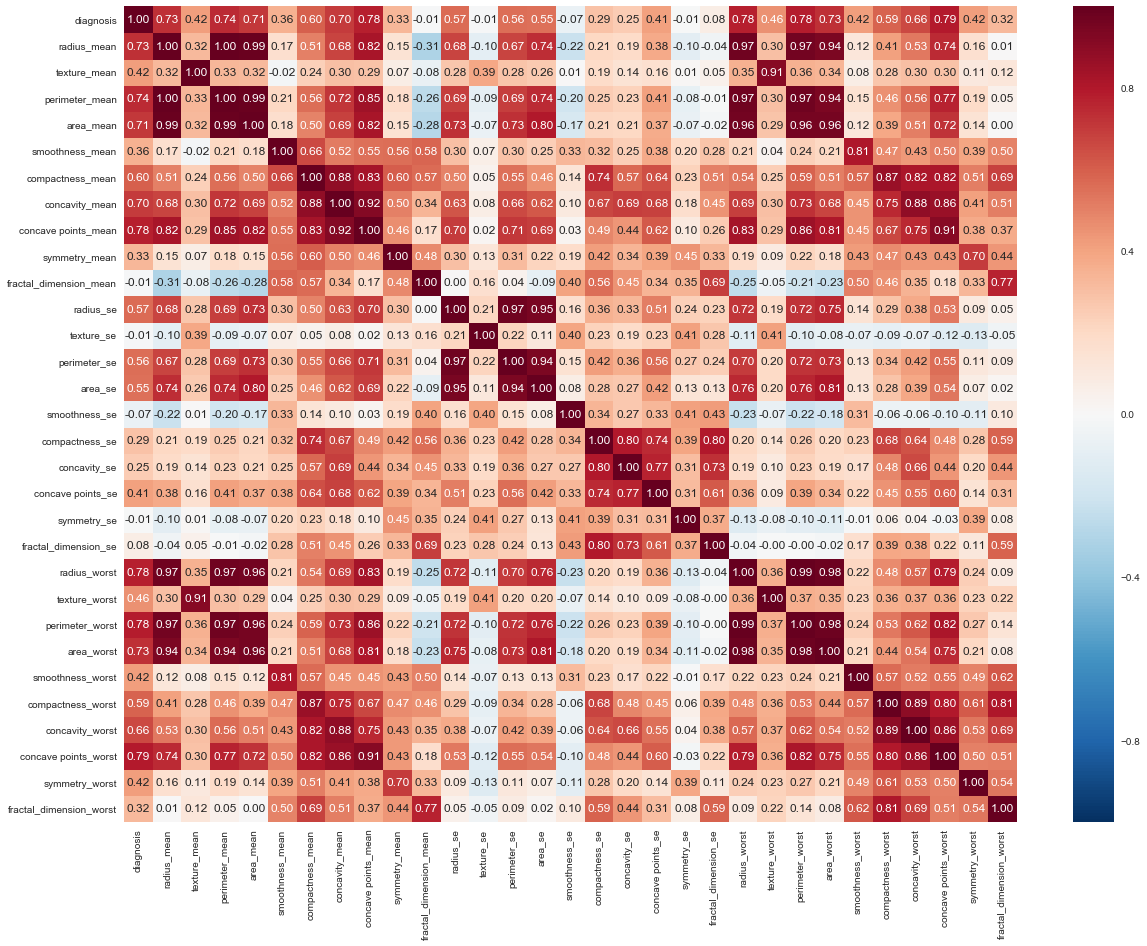

In [9]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(),annot=True,fmt=".2f")

## Feature Selection / Examining Feature Importance

In [10]:
# Split dataset into training and testing subsets
from sklearn.model_selection import train_test_split

X = df.drop('diagnosis',axis=1)
y = df['diagnosis']

radius_mean = 0.0442670318025
texture_mean = 0.0151128056197
perimeter_mean = 0.0474538785292
area_mean = 0.0478537078097
smoothness_mean = 0.00645138215194
compactness_mean = 0.0125752725474
concavity_mean = 0.0512330138464
concave points_mean = 0.0984874634814
symmetry_mean = 0.00374209790461
fractal_dimension_mean = 0.00343838258046
radius_se = 0.0172453302251
texture_se = 0.00379146004377
perimeter_se = 0.010364906709
area_se = 0.03511755308
smoothness_se = 0.00486633653987
compactness_se = 0.00455103703769
concavity_se = 0.00581039443664
concave points_se = 0.00685793773048
symmetry_se = 0.00387676386115
fractal_dimension_se = 0.00475989533513
radius_worst = 0.0870230465133
texture_worst = 0.0165789841137
perimeter_worst = 0.136217469891
area_worst = 0.12723344927
smoothness_worst = 0.0126122963413
compactness_worst = 0.0158982746461
concavity_worst = 0.0350440041459
concave points_worst = 0.125510671074
symmetry_worst = 0.00960960128921
fractal_dimension_worst = 0.00641555144319


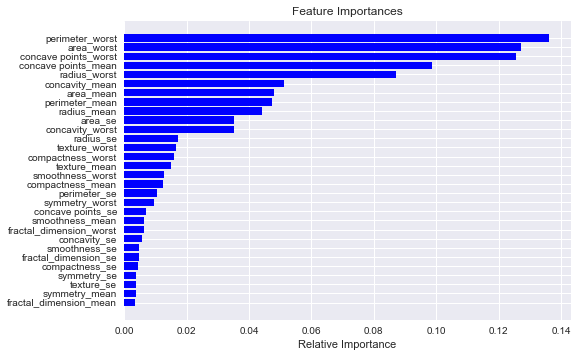

In [11]:
from sklearn.ensemble import RandomForestClassifier

#Assessing feature importance 
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(X,y)
for name, importance in zip(X.columns, rnd_clf.feature_importances_):
     print(name, "=", importance)
        
features = X.columns
importances = rnd_clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

### Anova F-value

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

For feature selection, we'll use the anova f-value. For ANOVA, one variable must be categorical and the other must be continuous -- our data match these parameters making it an appropriate approach for feature selection. 

In [13]:
from sklearn.feature_selection import f_classif
selector = SelectKBest(f_classif,k=5)
selector.fit(X,y)
mask = selector.get_support(indices=True)
fval_features = X.columns[mask]

In [14]:
fval_features

Index(['perimeter_mean', 'concave points_mean', 'radius_worst',
       'perimeter_worst', 'concave points_worst'],
      dtype='object')

### PCA

We have a lot of redundant features -- let's perform PCA to help with address this. Most of the variance is explained in the first principle component which comes as no surprise given the redundancies present in the correlation heatmap. For our testing just the first principal component. 

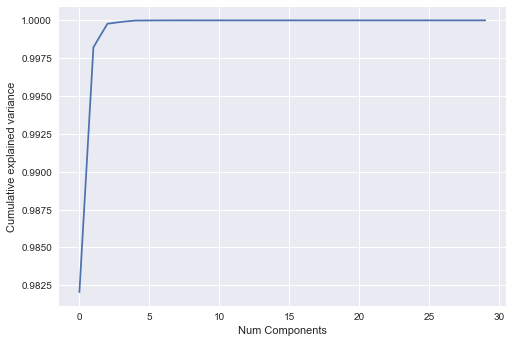

In [15]:
from sklearn.decomposition import PCA
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Num Components')
plt.ylabel('Cumulative explained variance')

In [16]:
pca.explained_variance_ratio_

array([ 0.98204467,  0.01617649,  0.00155751,  0.00012093,  0.00008827,
        0.00000665,  0.00000402,  0.00000082,  0.00000034,  0.00000019,
        0.00000007,  0.00000002,  0.00000001,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [17]:
components = 1

## Model

For this dataset, we'll oversample. There is a risk of overfitting since we'll be duplicating observations from minority class, however since the imbalance isn't too drastic the benefit of having balanced classes probably outweighs any risk of overfitting. 

In [18]:
# Oversample data
# Good because no information loss, however there is increased chance of overfitting
# due to replication of minority classes
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12)

X, y = sm.fit_sample(X, y)

# Split dataset into training and testing subsets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state=12)

# Verify that data are resampled
print("Verify balanced classes:",np.unique(y,return_counts=True))

Verify balanced classes: (array([0, 1]), array([357, 357]))


In [19]:
# Establish number of features to test each time during grid search
features = list(range(1,len(df.columns),3))

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import time

kbest = SelectKBest(f_classif)
pipeline = Pipeline([('kbest', kbest), ('lr', LogisticRegression())])
grid_search = GridSearchCV(pipeline, {'kbest__k': list(range(1,31,3)), 'lr__C': np.logspace(-10, 10, 5)})
grid_search.fit(X, y)

# Construct some pipelines
pipe_lr = Pipeline([('kbest', kbest),
            ('scl', StandardScaler()),
            ('clf', LogisticRegression(random_state=42))])

pipe_lr_pca = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=components)),
            ('clf', LogisticRegression(random_state=42))])

pipe_rf = Pipeline([('kbest', kbest),
            ('scl', StandardScaler()),
            ('clf', RandomForestClassifier(random_state=42))])

pipe_rf_pca = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=components)),
            ('clf', RandomForestClassifier(random_state=42))])

pipe_svm = Pipeline([('kbest', kbest),
            ('scl', StandardScaler()),
            ('clf', svm.SVC(random_state=42))])

pipe_svm_pca = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=components)),
            ('clf', svm.SVC(random_state=42))])

pipe_knn = Pipeline([('kbest', kbest),
                    ('scl',StandardScaler()),
                    ('clf',KNeighborsClassifier())])

pipe_knn_pca = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=components)),
            ('clf', KNeighborsClassifier())])

pipe_nb = Pipeline([('kbest', kbest),
            ('scl', StandardScaler()),
            ('clf', BernoulliNB())])

pipe_nb_pca = Pipeline([('scl', StandardScaler()),
            ('clf', BernoulliNB())])

pipe_tree = Pipeline([('kbest', kbest),
            ('scl', StandardScaler()),
            ('clf', DecisionTreeClassifier())])

pipe_tree_pca = Pipeline([('scl', StandardScaler()),
            ('clf', DecisionTreeClassifier())])

pipe_gb = Pipeline([('kbest', kbest),
            ('scl', StandardScaler()),
            ('clf', GradientBoostingClassifier())])

pipe_gb_pca = Pipeline([('scl', StandardScaler()),
            ('clf', GradientBoostingClassifier())])

# Set grid search params
param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param_range_fl = [1.0, 0.5, 0.1]

grid_params_lr = [{'kbest__k': features,
        'clf__penalty': ['l1', 'l2'],
        'clf__C': param_range_fl,
        'clf__solver': ['liblinear']}] 

grid_params_lr_pca = [{'clf__penalty': ['l1', 'l2'],
        'clf__C': param_range_fl,
        'clf__solver': ['liblinear']}] 

grid_params_rf = [{'kbest__k': features,
        'clf__criterion': ['gini', 'entropy'],
        'clf__min_samples_leaf': param_range,
        'clf__max_depth': param_range,
        'clf__min_samples_split': param_range[1:]}]

grid_params_rf_pca = [{'clf__criterion': ['gini', 'entropy'],
        'clf__min_samples_leaf': param_range,
        'clf__max_depth': param_range,
        'clf__min_samples_split': param_range[1:]}]

grid_params_svm = [{'kbest__k': features,
        'clf__kernel': ['linear', 'rbf'], 
        'clf__C': param_range}]

grid_params_svm_pca = [{'clf__kernel': ['linear', 'rbf'], 
        'clf__C': param_range}]

grid_params_knn = [{
        'kbest__k': features,
        'clf__n_neighbors': [1,2,3,4,5,6,7,8,9,10], 
        'clf__weights': ['uniform','distance'],
        'clf__algorithm':['ball_tree','brute','auto'],
        'clf__leaf_size':[10,20,30,40,50,60,70,80,90,100]}]

grid_params_knn_pca = [{'clf__n_neighbors': [1,2,3,4,5,6,7,8,9,10], 
        'clf__weights': ['uniform','distance'],
        'clf__algorithm':['ball_tree','brute','auto'],
        'clf__leaf_size':[10,20,30,40,50,60,70,80,90,100]}]

grid_params_nb = [{'kbest__k':features,
                   'clf__alpha': param_range_fl}]

grid_params_nb_pca = [{'clf__alpha': param_range_fl}]

grid_params_tree = [{'kbest__k':features,
                   'clf__criterion': ['gini','entropy'],
                   'clf__splitter': ['best','random']}]

grid_params_tree_pca = [{'clf__criterion': ['gini','entropy'],
                   'clf__splitter': ['best','random']}]

grid_params_gb = [{'kbest__k':features,
                   'clf__loss': ['deviance','exponential'],
                   'clf__n_estimators': [100,200,300,400,500],
                   'clf__max_depth': [2,4,6,8,10]}]

grid_params_gb_pca = [{'clf__loss': ['deviance','exponential'],
                   'clf__n_estimators': [100,200,300,400,500],
                   'clf__max_depth': [2,4,6,8,10]}]


# Construct grid searches
jobs = -1

gs_lr = GridSearchCV(estimator=pipe_lr,
            param_grid=grid_params_lr,
            scoring='accuracy',
            cv=10) 

gs_lr_pca = GridSearchCV(estimator=pipe_lr_pca,
            param_grid=grid_params_lr_pca,
            scoring='accuracy',
            cv=10)

gs_rf = GridSearchCV(estimator=pipe_rf,
            param_grid=grid_params_rf,
            scoring='accuracy',
            cv=10, 
            n_jobs=jobs)

gs_rf_pca = GridSearchCV(estimator=pipe_rf_pca,
            param_grid=grid_params_rf_pca,
            scoring='accuracy',
            cv=10, 
            n_jobs=jobs)

gs_svm = GridSearchCV(estimator=pipe_svm,
            param_grid=grid_params_svm,
            scoring='accuracy',
            cv=10,
            n_jobs=jobs)

gs_svm_pca = GridSearchCV(estimator=pipe_svm_pca,
            param_grid=grid_params_svm_pca,
            scoring='accuracy',
            cv=10,
            n_jobs=jobs)

gs_knn = GridSearchCV(estimator=pipe_knn,
            param_grid=grid_params_knn,
            scoring='accuracy',
            cv=10,
            n_jobs=jobs)

gs_knn_pca = GridSearchCV(estimator=pipe_knn_pca,
            param_grid=grid_params_knn_pca,
            scoring='accuracy',
            cv=10,
            n_jobs=jobs)

gs_nb = GridSearchCV(estimator=pipe_nb,
            param_grid=grid_params_nb,
            scoring='accuracy',
            cv=10,
            n_jobs=jobs)

gs_nb_pca = GridSearchCV(estimator=pipe_nb_pca,
            param_grid=grid_params_nb_pca,
            scoring='accuracy',
            cv=10,
            n_jobs=jobs)
                      
gs_tree = GridSearchCV(estimator=pipe_tree,
            param_grid=grid_params_tree,
            scoring='accuracy',
            cv=10,
            n_jobs=jobs)

gs_tree_pca = GridSearchCV(estimator=pipe_tree_pca,
            param_grid=grid_params_tree_pca,
            scoring='accuracy',
            cv=10,
            n_jobs=jobs)
                      
gs_gb = GridSearchCV(estimator=pipe_gb,
            param_grid=grid_params_gb,
            scoring='accuracy',
            cv=10,
            n_jobs=jobs)

gs_gb_pca = GridSearchCV(estimator=pipe_gb_pca,
            param_grid=grid_params_gb_pca,
            scoring='accuracy',
            cv=10,
            n_jobs=jobs)



# List of pipelines for ease of iteration
grids = [gs_lr, gs_lr_pca, gs_rf, gs_rf_pca, gs_svm, gs_svm_pca,gs_knn,gs_knn_pca,gs_nb,gs_nb_pca,
        gs_tree,gs_tree_pca,gs_gb,gs_gb_pca]



# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'Logistic Regression', 1: 'Logistic Regression w/PCA', 
        2: 'Random Forest', 3: 'Random Forest w/PCA', 
        4: 'Support Vector Machine', 5: 'Support Vector Machine w/PCA', 6: 'K Nearest Neighbors',
            7: 'K Nearest Neighbors w/ PCA', 8: 'Naive Bayes',
            9: 'Naive Bayes w/ PCA',10:'Decision Tree',11:'Decision Tree w/ PCA',12:'Gradient Boosting',13:'Gradient Boosting w/ PCA'}
    


In [25]:
from time import time

In [28]:
model = []
training_accuracy = []
test_accuracy = []
t = []
classification_reports = []

import timeit
from sklearn.metrics import classification_report

# Fit the grid search objects
print('Performing model optimizations...')
best_acc = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    model.append(grid_dict[idx])
    # Fit grid search
    start = timeit.timeit()
    gs.fit(X_train, y_train)
    stop = timeit.timeit()
    t.append(start-stop)
    # Best params
    print('Best params: %s' % gs.best_params_)
    # Best training data accuracy
    print('Best training accuracy: %.3f' % gs.best_score_)
    training_accuracy.append(gs.best_score_)
    # Predict on test data with best params
    y_pred = gs.predict(X_test)
    # Test data accuracy of model with best params
    print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred))
    test_accuracy.append(accuracy_score(y_test, y_pred))
    # Track best (highest test accuracy) model
    if accuracy_score(y_test, y_pred) > best_acc:
        best_acc = accuracy_score(y_test, y_pred)
        best_gs = gs
        best_clf = idx
    classification_reports.append(classification_report(y_test,y_pred,target_names=['B','M']))
print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])

# Save best grid search pipeline to file
dump_file = 'best_gs_pipeline.pkl'
joblib.dump(best_gs, dump_file, compress=1)
print('\nSaved %s grid search pipeline to file: %s' % (grid_dict[best_clf], dump_file))

Performing model optimizations...

Estimator: Logistic Regression
Best params: {'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__solver': 'liblinear', 'kbest__k': 28}
Best training accuracy: 0.975
Test set accuracy score for best params: 0.975 

Estimator: Logistic Regression w/PCA
Best params: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best training accuracy: 0.914
Test set accuracy score for best params: 0.924 

Estimator: Random Forest
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 2, 'kbest__k': 28}
Best training accuracy: 0.971
Test set accuracy score for best params: 0.975 

Estimator: Random Forest w/PCA
Best params: {'clf__criterion': 'gini', 'clf__max_depth': 1, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
Best training accuracy: 0.916
Test set accuracy score for best params: 0.932 

Estimator: Support Vector Machine
Best params: {'clf__C': 1, 'clf__kernel': 'linear', 'kbest__k'

In [33]:
results = pd.DataFrame()

results['model'] = model
results['training_accuracy'] = training_accuracy
results['test_accuracy'] = test_accuracy
results['run_time'] = t
results['class_report'] = classification_reports

results.sort_values(by=['test_accuracy'],ascending=False)

,model,training_accuracy,test_accuracy,run_time,class_report
6,K Nearest Neighbors,0.969,0.979,-0.003,precision recall f1-score s...
13,Gradient Boosting w/ PCA,0.964,0.979,0.000,precision recall f1-score s...
0,Logistic Regression,0.975,0.975,0.001,precision recall f1-score s...
2,Random Forest,0.971,0.975,-0.003,precision recall f1-score s...
12,Gradient Boosting,0.969,0.975,0.000,precision recall f1-score s...
4,Support Vector Machine,0.975,0.970,-0.001,precision recall f1-score s...
8,Naive Bayes,0.941,0.953,0.000,precision recall f1-score s...
5,Support Vector Machine w/PCA,0.914,0.945,0.000,precision recall f1-score s...
9,Naive Bayes w/ PCA,0.937,0.936,-0.000,precision recall f1-score s...
3,Random Forest w/PCA,0.916,0.932,0.003,precision recall f1-score s...


In [36]:
print(results['class_report'][6])

             precision    recall  f1-score   support

          B       0.98      0.97      0.98       107
          M       0.98      0.98      0.98       129

avg / total       0.98      0.98      0.98       236



The model we'll pick is KNN with 19 features selected using the anova f-value. The precision and recall scores during testing yielded superior results relative to other models with 98% of identifications being correct (precision) and 98%/97% of malignant and benign classifications being correctly identified (recall). 

In every instances with the exception of gradient boosting, performance on the test data dropped when using the first principal component. It's possible that a small but extremely meaningful information was lost during dimensionality reduction which imaired model performance. 
